# A gentle practical intro to adversarial ML using pytorch and cleverhans

FOM Seminars, by D. Rios, V. Gallego, R. Naveiro.


* Pytorch https://pytorch.org/ es un framework popular de deep learning que puede utilizar la GPU.
* cleverhans https://github.com/tensorflow/cleverhans es una librería de ejemplos adversarios para construir ataques, defensas y validar ambos.


## AML en imágenes

Primero, cargamos las librerías necesarias

In [146]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
from tensorflow.python.platform import flags
from torch.autograd import Variable
from torchvision import datasets, transforms

from cleverhans.attacks import FastGradientMethod
from cleverhans.model import CallableModelWrapper
from cleverhans.utils import AccuracyReport
from cleverhans.utils_pytorch import convert_pytorch_model_to_tf

# Fijamos las semillas de los generadores de números aleatorios
tf.set_random_seed(1234)
torch.manual_seed(1234)
np.random.seed(1234)
import warnings
warnings.filterwarnings("ignore")

In [147]:
torch.__version__

'0.4.1'

Definimos nuestro modelo, será una red convolucional sencilla

* La función **forward** implementa la función que va aprendiendo la red

Como vamos a utilizar el dataset de imágenes MNIST (http://yann.lecun.com/exdb/mnist/), parece razonable utilizar alguna arquitectura basada en capas convolucionales

In [148]:
class SimpleCNN(nn.Module):
    """ Basic MNIST model from github
    """

    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64 * 7 * 7)  # reshape Variable
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

Vamos a echar un vistazo a la arquitectura, que consiste en dos capas convolucionales y otras dos capas densas

In [149]:
cnn = SimpleCNN()
cnn

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

Con ayuda de https://github.com/szagoruyko/pytorchviz visualizaremos la red

In [150]:
from torchviz import make_dot

Los parámetros a entrenar vienen marcados en azul

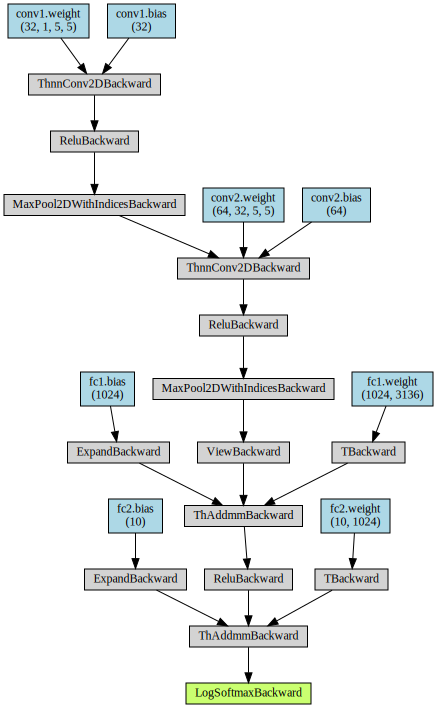

In [151]:
random_input = torch.randn([1, 1, 28, 28])

make_dot(cnn(random_input), params=dict(cnn.named_parameters()))

Declaramos los hiperparámetros

* n_epochs: número de épocas sobre el que entrenaremos
* batch_size: cuántos ejemplos usa la red en cada actualización
* lr: tasa de aprendizaje

In [152]:
n_epochs = 6
batch_size = 128
lr = .001

Comprobamos si hay GPU y cargamos el dataset MNIST

In [153]:
torch_model = SimpleCNN()

if torch.cuda.is_available():
    torch_model = torch_model.cuda()
report = AccuracyReport()

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size)

train_end=-1
test_end=-1
train_loader.dataset.train_data = train_loader.dataset.train_data[:train_end]
test_loader.dataset.test_data = test_loader.dataset.test_data[:test_end]

Ya estamos listos para entrenar el modelo. Utilizaremos el optimizador Adam [Kingma, https://arxiv.org/abs/1412.6980], una variante efectiva del descenso por el gradiente estocástico (SGD).


In [154]:
# Entrenamiento
optimizer = optim.Adam(torch_model.parameters(), lr=lr)
train_loss = []

total = 0
correct = 0
step = 0
for epoch in range(n_epochs):
    for xs, ys in train_loader:
        xs, ys = Variable(xs), Variable(ys)
        if torch.cuda.is_available():
            xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        
        # Calculamos las predicciones
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        
        # Calculamos gradientes (backpropagation)
        loss.backward()  
        train_loss.append(loss.data.item())
        
        # Actualizamos los parámetros de la red
        optimizer.step()  

        preds_np = preds.data.cpu().numpy()
        correct += (np.argmax(preds_np, axis=1) == ys).sum()
        total += len(xs)
        step += 1
        if total % 1000 == 0:
            acc = float(correct) / total
            print('[%s] Training accuracy: %.2f%%' % (step, acc * 100))
            total = 0
            correct = 0

[125] Training accuracy: 88.98%


KeyboardInterrupt: 

En lugar de entrenar ahora mismo, cargaremos unos pesos ya preentrenados

In [15]:
# torch.save(torch_model.state_dict(), 'cnn_weights.bin')

In [155]:
torch_model = SimpleCNN()
torch_model.load_state_dict(torch.load('cnn_weights.bin'))

Evaluamos sobre un conjunto de test limpio (sin atacar)

In [156]:
total = 0
correct = 0
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    if torch.cuda.is_available():
        xs, ys = xs.cuda(), ys.cuda()

    preds = torch_model(xs)
    preds_np = preds.data.cpu().numpy()

    correct += (np.argmax(preds_np, axis=1) == ys).sum()
    total += len(xs)

acc = float(correct) / total
report.clean_train_clean_eval = acc
print('[%s] Clean accuracy: %.2f%%' % (step, acc * 100))

[241] Clean accuracy: 99.11%


Obtenemos unos resultados bastante razonables

## Evaluando nuestro clasificador bajo ataques adversarios

In [157]:
# Utilizamos cleverhans para evaluar sobre inputs adversarios
sess = tf.Session()
x_op = tf.placeholder(tf.float32, shape=(None, 1, 28, 28,))

# Convertimos el modelo de torch a tf
tf_model_fn = convert_pytorch_model_to_tf(torch_model)
cleverhans_model = CallableModelWrapper(tf_model_fn, output_layer='logits')

Ahora, realizaremos el ataque *fast gradient sign method* (FGSM), uno de los primeros ataques exitosos contra redes neuronales profundas. Fue introducido por Goodfellow et al en 2014 https://arxiv.org/abs/1412.6572

La idea principal consiste en perturbar ligeramente una imagen original $x$ siguiendo el signo del gradiente de la funcion objetivo $\mathcal{L}$:

$$
x' = x + \epsilon \mbox{sign}(\nabla_x \mathcal{L}(x,y,\theta))
$$

In [159]:
# Create an FGSM attack
fgsm_op = FastGradientMethod(cleverhans_model, sess=sess)
fgsm_params = {'eps': 0.1}

adv_x_op = fgsm_op.generate(x_op, **fgsm_params)
adv_preds_op = tf_model_fn(adv_x_op)

In [160]:
# Evaluamos el modelo bajo el dataset de test atacado
total = 0
correct = 0
for xs, ys in test_loader:
    adv_preds = sess.run(adv_preds_op, feed_dict={x_op: xs})
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()
    total += len(xs)

acc = float(correct) / total
print('Adv accuracy: {:.3f} %'.format(acc * 100))

Adv accuracy: 62.056 %


Como podemos ver, el rendimiento de nuestro clasificador neuronal se ve gravemente perjudicado después de que hayamos atacado el conjunto de test: del 99% al 62% de accuracy.

Tomaremos un ejemplo para verlo en más detalle

In [161]:
%matplotlib inline
import matplotlib.pyplot as plt

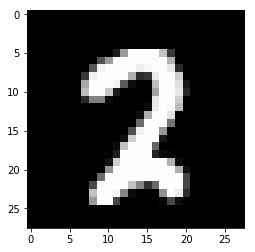

In [162]:
idx = 1
sample = xs[idx]
plt.imshow(sample.numpy()[0,:,:], cmap='gray')

In [163]:
sample.requires_grad = True  # Necesitamos esto para calcular el gradiente
output = torch_model(sample.unsqueeze(0))
print('Clase predicha:', torch.argmax( output ).numpy())

Clase predicha: 2


Parece que el ejemplo previo fue correctamente clasificado. Veamos qué ocurre bajo el ataque FGSM

In [164]:
# Calculamos el gradiente
F.nll_loss(output, ys[idx].unsqueeze(0)).backward()

Ahora, ya tenemos calculado $\nabla_x \mathcal{L}(x,y,\theta)$:

In [166]:
sample.grad.shape

torch.Size([1, 28, 28])

Realizaremos manualmente el ataque FGSM:

In [167]:
adv_sample = sample + 0.1*torch.sign(sample.grad)

In [168]:
adv_output = torch_model(adv_sample.unsqueeze(0))
print('Clase predicha:', torch.argmax( adv_output ).numpy())

Clase predicha: 7


Parece que hemos engañado a nuestro clasificador otra vez... ¿Cuál es el aspecto visual del input malicioso?

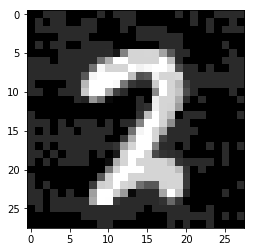

In [169]:
plt.imshow(adv_sample.detach().numpy()[0,:,:], cmap='gray')

Esto no se parece a un 7..

## Transferencia de ejemplos adversarios

¿Qué ocurre si usamos el mismo ejemplo adversario en otro modelo distinto (black-box attack)?

In [170]:
class AnotherCNN(nn.Module):

    def __init__(self):
        super(AnotherCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 100)
        self.fc11 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 32 * 7 * 7)  # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc11(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [140]:
another_model = AnotherCNN()

In [171]:
another_model = AnotherCNN()
another_model.load_state_dict(torch.load('another_cnn_weights.bin'))

In [172]:
another_model

AnotherCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=100, bias=True)
  (fc11): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [173]:
adv_output = another_model(adv_sample.unsqueeze(0))
print('Clase predicha:', torch.argmax( adv_output ).numpy())

Clase predicha: 7


## ¿Qué ocurre con perturbaciones no adversarias?

In [174]:
sample_rand = sample + 0.2*torch.randn_like(sample)

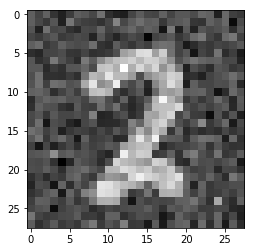

In [175]:
plt.imshow(sample_rand.detach().numpy()[0,:,:], cmap='gray')

In [176]:
rand_output = another_model(sample_rand.unsqueeze(0))
print('Clase predicha:', torch.argmax( rand_output ).numpy())

Clase predicha: 2
